In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from codes.single_measurement_vector import single_measurement_vector
from codes.residual_ratio_thresholding import residual_ratio_thresholding


# Problem Statement

Consider a single measurement vector (SMV) linear regression model $${\bf Y}={\bf X}{\bf B}+{\bf W}$$ where ${\bf X} \in \mathbb{R}^{nsamples\times nfeatures} $ is a known design matrix and ${\bf B} \in \mathbb{R}^{nfeatures\times 1}$ is an unknown sparse vector with $sparsity=k_0=\|{\bf B}\|_0\ll nfeatures$. ${\bf W} \in \mathbb{R}^{nsamples\times 1}$ is a noise vector (for theoretical purposes only)  with each entries $\mathcal{N}(0,\sigma^2)$ distributed. 

The problem we address here is the estimation of ${\bf B}$ when $k_0$ and $\sigma^2$ are both unknown. We consider a high dimensional scenario where $nsamples\ll nfeatures$. Under these constraints, it is difficult to estimate ${\bf B}$ with finite sample guarantees.  Most (not all) popular algorithms including OMP, LASSO, subspace pursuit, Dantzig selector etc. can deliver estimation  with theoretical (especially restricted isometry property ) guarantees require $\textit{a priori}$ knowledge of $k_0$ and/or $\sigma^2$.

In our 2018 ICML paper http://proceedings.mlr.press/v80/kallummil18a.html we proposed residual ratio thresholding (RRT) as a tool to estimate ${\bf B}$ using OMP without requiring $\textit{a priori}$ knowledge of $k_0$ and/or $\sigma^2$. This concept was later extended in a recent article (https://arxiv.org/pdf/1912.08637.pdf under review in IEEE TSP) to operate LASSO without requiring $\textit{a priori}$ knowledge of $k_0$ and/or $\sigma^2$.
Here, we illustrate  how to use RRT in this problem setting. 


# Concept  of RRT

Suppose we are given an ordered sequence of support estimates $\mathcal{S_1},\mathcal{S}_2...\mathcal{S}_{k_{max}}$ such that  a $card(\mathcal{S}_k)=k$ and $\mathcal{S}_k\subset \mathcal{S}_{k+1}$.  Corresponding to each support $\mathcal{S}_k$, one can compute the corresponding least squares residuals as ${\bf R}^k=({\bf I}_{nsamples}-{\bf P}(\mathcal{S}_k)){\bf Y}$, where ${\bf P}(\mathcal{S}_k)$ is the projection onto the column space spanned by ${\bf X}[:,\mathcal{S}_k]$. The corresponding residual ratios are defined as $$RR(k)=\dfrac{\|{\bf R}^k\|_2}{\|{\bf R}^{k-1}\|_2}$$. 

This statistic satisfies some interesting properties. 

Under appropriate conditions on the matrix ${\bf X}$, SNR and sparsity $k_0$, many algorithms can generate support estimate sequences that satisfy $\mathcal{S}_{k_0}=\mathcal{S}$, the true unknown support of ${\bf B}$. If those conditions are true then 

$$1). \ \ RR(k_0)\rightarrow 0  \ \text{as} \ \sigma^2\rightarrow 0$$.  

$$2). \ \ \mathbb{P}(RR(k)>\Gamma_{RRT}^{\alpha}(k),\ \text{for all} \ k=k_0+1,....k_{max})>1-\alpha$$

where $$\Gamma_{RRT}^{\alpha}(k)=\sqrt{F_{\frac{nsamples-k}{2},\frac{1}{2}}^{-1}\left(\frac{\alpha}{(nfeatures-k+1)}\right)}$$
is a sequence of RRT thresholds. $F_{a,b}(x)$ is the CDF of a Beta random variable with parameters $a$ and $b$ and $F^{-1}$ is the inverse function of $F$.  

Properties 1 and 2 of $RR(k)$ means that the RRT estimate of sparsity given by $$k_{RRT}=\max\{k:RR(k)<\Gamma_{RRT}^{\alpha}(k)\}$$ will be equal to true unknown sparsity $k_0$ and $\mathcal{S}_{k_{RRT}}$ will be equal to the true unknown support $\mathcal{S}$ at high enough SNR. 




# Usage

${\bf Given}$:  Y and X. We assume that X has unit $l_2$ norm columns. 

${\bf Step 1}$ : Instantiate the class and RRT class 

        a). smv=single_measurement_vector()

        b). rrt=residual_ratio_thresholding(nsamples,nfeatures,alpha_list=[0.1],
                                    nchannels=1,group_size=1,scenario='compressed_sensing:SMV') 
                                    
${\bf Step \ 2}$ : Generate residual ratios $RR(k)$ and ordered support estimate sequence $\mathcal{S}_k,k=1,2,..$  using SMV class 

        a). res_ratio,ordered_support_estimate_sequence=smv.generate_residual_ratios(X,Y,'LASSO') or 
        
        b). res_ratio,ordered_support_estimate_sequence=smv.generate_residual_ratios(X,Y,'OMP')
        
${\bf Step \ 3}$  : Compute the support estimate using RRT from $RR(k)$ and $\mathcal{S}_k$. 

        a).  results=rrt.estimate_support(ordered_support_estimate_sequence,res_ratio)
        
        b).  support_estimate=results[0.1]. # 0.1 is the value of alpha used in alpha_list. You can give multiple values of alphas in alpha_list. results is a dictionary with alpha as key and corresponding support estimate as value. 
        
${\bf Step \ 4}:$  Compute the least squares estimate of ${\bf B}$ using ${\bf X}$, ${\bf Y}$ and the estimated support.

        a). B_est= smv.generate_estimate_from_support(X,Y,support=results_lasso[0.1])
        
One can easily club these steps into one single function which can take X,Y as input and gives support estimate, B_est as outputs.   


# How to use functions other than OMP and LASSO in  RRT framework. 

Any algorithm that can deliver a support estimate of the form $\mathcal{S}_k=Alg(X,Y,k)$ with $card(\mathcal{S}_k)=k$ can be used in RRT. 

${\bf Step 1}$: Generate $\mathcal{S}_k=Alg(X,Y,k)$ for k=1,2,..,$k_{max}$. We typically set $k_max=\min\left(nfeatures,0.5(nsamples+1)\right)$. 

${\bf Step 2:}$ The support sequence generated by Alg may not be monotonically increasing, i.e., $\mathcal{S}_k\subset \mathcal{S}_{k+1}$. Convert non monotnic support sequence to monotonic support sequence 

    a). ordered_support_estimate_sequence= smv.generate_ordered_sequence(self,support_estimate_sequence,kmax)
    
${\bf Step 3:}$  Generate residual ratios corresponding to the ordered_support_estimate_sequence. 

    a). res_ratios=smv.res_ratios_from_ordered_sequence(ordered_support_estimate_sequence,X,Y)
    
${\bf Step 4:}$  Apply RRT on res_ratios and ordered_support_estimate_sequence. Follow steps 3 and 4 in the previous cell. 
    
    




# Other utility functions

    1). X,Y,Beta_true,support_true,noisevar=smv.generate_random_example(nsamples=32,nfeatures=64,sparsity=3,SNR_db=20)
    
This function generates a linear regression model using Gaussian matrices which is further normalized to have $l_2$ columns, a sparse vector with non zero entries randomly assigned $\pm1$  and Gaussian noise of noise variance determined by the required SNR. 

    2). support_error,l2_error=smv.compute_error(support_true,support_estimate,
                                                 Beta_true,Beta_estimate)
                                                
This function computes the support recovery error (=1 if support estimate!= support_true else 0) and $l_2$ error between ${\bf B}$ and its estimate.  

    3). support_est,Beta_est=smv.OMP_prior_sparsity(X,Y,sparsity=len(support_true))
    
This function computes OMP support estimate when provided with the apriori value of sparsity level $k_0$. Good baseline. 
                    

###  Example: Generate a sparse regression problem


In [9]:
smv=single_measurement_vector();
X,Y,Beta_true,support_true,noisevar=smv.generate_random_example(nsamples=32,nfeatures=64,sparsity=3,SNR_db=20)
print('Unknown sparse vector Beta is')
print(Beta_true.flatten())
print('Support of Beta is')
print(support_true)

Unknown sparse vector Beta is
[-1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Support of Beta is
[0, 1, 2]


### Behaviour of  residual ratio statistic $RR(k)$




[2, 0, 1, 24, 12, 57, 5, 35, 17, 39, 10, 25, 56, 53, 22, 40]
[2, 1, 0, 57, 39, 8, 43, 55, 25, 53, 40, 33, 24, 9, 62, 4]


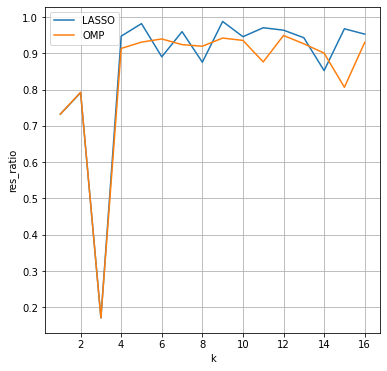

In [10]:
plt.figure(figsize=(6,6))
res_ratio_lasso,ordered_support_estimate_sequence_lasso=smv.generate_residual_ratios(X,Y,'LASSO')
print(ordered_support_estimate_sequence_lasso)
plt.plot(np.arange(len(res_ratio_lasso))+1,res_ratio_lasso,label='LASSO')
res_ratio_omp,ordered_support_estimate_sequence_omp=smv.generate_residual_ratios(X,Y,'OMP')
print(ordered_support_estimate_sequence_omp)
plt.plot(np.arange(len(res_ratio_omp))+1,res_ratio_omp,label='OMP')
plt.grid()
plt.xlabel('k'); plt.ylabel('res_ratio')
plt.legend()

###  Behaviour of RRT thresholds $\Gamma_{RRT}^{\alpha}(k)$

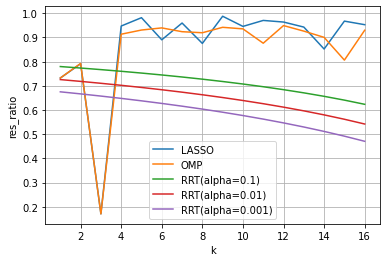

In [11]:
rrt=residual_ratio_thresholding(nsamples=32,nfeatures=64,
                                        alpha_list=[0.1,0.01,0.001],nchannels=1, 
                                group_size=1,scenario='compressed_sensing:SMV')

results=rrt.estimate_support(ordered_support_estimate_sequence_lasso,res_ratio_lasso) 
tres1=rrt.threshold_dict[0.1]['direct']
tres2=rrt.threshold_dict[0.01]['direct']
tres3=rrt.threshold_dict[0.001]['direct']

plt.figure()
kmax=len(res_ratio_omp)
plt.plot(np.arange(kmax)+1,res_ratio_lasso,label='LASSO')
plt.plot(np.arange(kmax)+1,res_ratio_omp,label='OMP')
plt.plot(np.arange(kmax)+1,tres1,label='RRT(alpha=0.1)')
plt.plot(np.arange(kmax)+1,tres2,label='RRT(alpha=0.01)')
plt.plot(np.arange(kmax)+1,tres3,label='RRT(alpha=0.001)')

plt.grid()
plt.xlabel('k'); plt.ylabel('res_ratio')
plt.legend()

### Example: RRT estimation

In [12]:
results_lasso=rrt.estimate_support(ordered_support_estimate_sequence_lasso,res_ratio_lasso)
results_omp=rrt.estimate_support(ordered_support_estimate_sequence_omp,res_ratio_omp)
print('True_support')
print(support_true)
print('Estimated_support:LASSO')
print(results_lasso[0.1])
print('Estimated_support:OMP')
print(results_omp[0.1])
Beta_est_lasso=smv.generate_estimate_from_support(X,Y,support=results_lasso[0.1])
Beta_est_omp=smv.generate_estimate_from_support(X,Y,support=results_omp[0.1])

True_support
[0, 1, 2]
Estimated_support:LASSO
[2, 0, 1]
Estimated_support:OMP
[2, 1, 0]


# Evaluating performance. 

We compare the performanc of OMP and LASSO operated using RRT against a simple baseline. An OMP algorithm operated using a priori knowledge of sparsity $k_0$. Except at low SNR, LASSO and OMP operated using RRT matches the support aware oracle. In our papers, we compare RRT with OMP and LASSO provided with many OMP and LASSO based schemes.  IN most of our experiments, we found that the performance GAP between OMP/LASSO with a priori known sparsity and noise variance and OMP/LASSO operate dusing RRT is minimal. 

In [20]:
SNR_db=np.linspace(0,30,10)
L2_ERROR_LASSO=np.zeros(10); L2_ERROR_OMP=np.zeros(10);L2_ERROR_BASELINE=np.zeros(10)
SUPPORT_ERROR_LASSO=np.zeros(10); SUPPORT_ERROR_OMP=np.zeros(10);SUPPORT_ERROR_BASELINE=np.zeros(10)
num_iter=100; # number of montecarlo iterations for each example. 
nsamples=32;nfeatures=64;sparsity=3;

smv=single_measurement_vector();
rrt=residual_ratio_thresholding(nsamples=nsamples,nfeatures=nfeatures,
                                        alpha_list=[0.1],nchannels=1, group_size=1,scenario='compressed_sensing:SMV')

for s in np.arange(len(SNR_db)):
    snr_db=SNR_db[s]
    l2_error_lasso=0;l2_error_omp=0;l2_error_baseline=0;
    support_error_lasso=0;support_error_omp=0;support_error_baseline=0;
    for num in np.arange(num_iter):
        X,Y,Beta_true,support_true,noisevar=smv.generate_random_example(nsamples=nsamples,nfeatures=nfeatures,
                                                                        sparsity=sparsity,SNR_db=snr_db)
        res_ratio_lasso,ordered_support_estimate_sequence_lasso=smv.generate_residual_ratios(X,Y,'LASSO')
        res_ratio_omp,ordered_support_estimate_sequence_omp=smv.generate_residual_ratios(X,Y,'OMP')
        results_lasso=rrt.estimate_support(ordered_support_estimate_sequence_lasso,res_ratio_lasso)
        results_omp=rrt.estimate_support(ordered_support_estimate_sequence_omp,res_ratio_omp)
        Beta_est_lasso=smv.generate_estimate_from_support(X,Y,support=results_lasso[0.1])
        Beta_est_omp=smv.generate_estimate_from_support(X,Y,support=results_omp[0.1])
        support_error,l2_error=smv.compute_error(support_true=support_true,support_estimate=results_lasso[0.1],
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_lasso)
        l2_error_lasso+=l2_error;support_error_lasso+=support_error

        support_error,l2_error=smv.compute_error(support_true=support_true,support_estimate=results_omp[0.1],
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_omp)
        l2_error_omp+=l2_error;support_error_omp+=support_error
        
        support_estimate_baseline,Beta_est_baseline=smv.OMP_prior_sparsity(X,Y,sparsity=len(support_true))
        support_error,l2_error=smv.compute_error(support_true=support_true,support_estimate=support_estimate_baseline,
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_baseline)
        l2_error_baseline+=l2_error;support_error_baseline+=support_error;
        
    L2_ERROR_LASSO[s]=l2_error_lasso/num_iter;L2_ERROR_OMP[s]=l2_error_omp/num_iter;L2_ERROR_BASELINE[s]=l2_error_baseline/num_iter
    SUPPORT_ERROR_LASSO[s]=support_error_lasso/num_iter;SUPPORT_ERROR_OMP[s]=support_error_omp/num_iter;
    SUPPORT_ERROR_BASELINE[s]=support_error_baseline/num_iter



Text(0, 0.5, 'support_recovery_error')

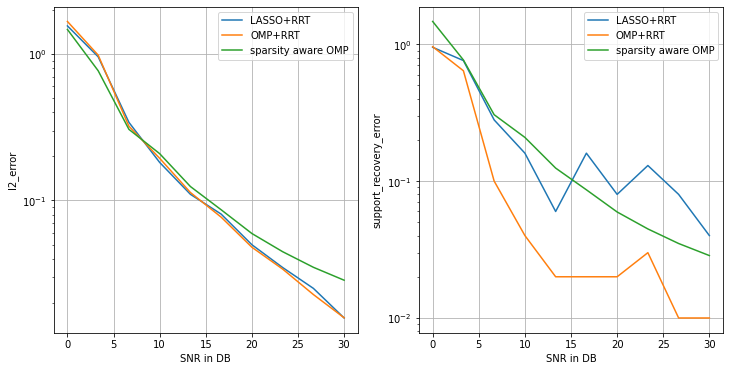

In [21]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.semilogy(SNR_db,L2_ERROR_LASSO,label='LASSO+RRT')
plt.semilogy(SNR_db,L2_ERROR_OMP,label='OMP+RRT')
plt.semilogy(SNR_db,L2_ERROR_BASELINE,label='sparsity aware OMP')
plt.grid()
plt.legend()
plt.xlabel('SNR in DB')
plt.ylabel('l2_error')  

plt.subplot(1,2,2)
plt.semilogy(SNR_db,SUPPORT_ERROR_LASSO,label='LASSO+RRT')
plt.semilogy(SNR_db,SUPPORT_ERROR_OMP,label='OMP+RRT')
plt.semilogy(SNR_db,L2_ERROR_BASELINE,label='sparsity aware OMP')
plt.grid()
plt.legend()
plt.xlabel('SNR in DB')
plt.ylabel('support_recovery_error')  